In [1]:
#
# Imports
#
import os
from argparse import Namespace
from types import MethodType
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect
from sqlalchemy.sql import func
import astropy.units as u
from astropy.constants import c as lightspeed
from astropy.table import Table, MaskedColumn
#
# DESI software
#
from desiutil.log import get_logger, DEBUG
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
# from desisim.spec_qa import redshifts as dsq_z
from desisurvey import __version__ as desisurvey_version
from desisurvey.ephem import get_ephem, get_object_interpolator
from desisurvey.utils import get_observer
from desispec import __version__ as desispec_version
import desispec.database.redshift as db
#
# Paths to files, etc.
#
specprod = os.environ['SPECPROD'] = 'fuji'
basedir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod)
# surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
# targetdir = os.path.join(basedir, 'targets')
# fibassigndir = os.path.join(basedir, 'fiberassign')
# os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
# os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
# os.environ['PIXPROD'] = 'mini'
# os.environ['SPECPROD'] = 'mini'
# reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
# simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
# os.environ['DESI_SPECTRO_DATA'] = simdatadir
#
# Initialize ephemerides, to find Moon, etc.
#
os.environ['DESISURVEY_OUTPUT'] = os.environ['SCRATCH']
ephem = get_ephem()
#
# get_ephem() will run freeze_iers(), so we import these after that.
#
from astropy.time import Time
from astropy.coordinates import ICRS
#
# Working directory.
#
workingdir = os.getcwd()
print(workingdir)
print(f'sqlalchemy=={sqlalchemy_version}')
print(f'desispec=={desispec_version}')
print(f'desisurvey=={desisurvey_version}')

INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephem.py:80:get_ephem: Restored ephemerides for (2019-01-01,2027-12-31) from /pscratch/sd/r/ronitnag/ephem_2019-01-01_2027-12-31.fits.
/global/u2/r/ronitnag/desi
sqlalchemy==1.4.46
desispec==0.57.0.dev7802
desisurvey==0.19.0.dev1131


In [2]:
import numpy as np
import glob
import os
import tempfile
import desispec.io 
import desispec.spectra
from desispec.io import read_spectra

In [44]:
postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi')

In [45]:
targetids = [39633414185291937, 39633414185291911, 39633414185291844]
q = db.dbSession.query(db.Fiberassign.targetid, db.Fiberassign.tileid, db.Tile.lastnight, db.Fiberassign.petal_loc).join(db.Tile)
q = q.filter(db.Fiberassign.tileid == db.Tile.tileid)
q = q.filter(db.Fiberassign.targetid.in_(targetids))
q = q.order_by(db.Fiberassign.targetid)

In [115]:
def getSpectra(tile_rows):
    results = list()
    for targetid, tileid, lastnight, petal_loc in tile_rows:
        folder = os.path.join('/global/cfs/cdirs/desi/spectro/redux/fuji', 'tiles', 'cumulative', str(tileid), str(lastnight))
        filename = f'coadd-{str(petal_loc)}-{str(tileid)}-thru{str(lastnight)}.fits'
        path = os.path.join(folder, filename)
        spectrafiles = glob.glob(path)
        if len(spectrafiles) != 1:
            raise ValueError(f'Unable to resolve file match to {filename}')

        coadd = desispec.io.read_spectra(spectrafiles[0], single=True)
        keep = (coadd.fibermap['TARGETID'] == targetid)
        if np.any(keep):
            results.append(coadd[keep])
    return results

In [116]:
tile_rows = q.all()

In [132]:
type(getSpectra(tile_rows))

INFO:spectra.py:291:read_spectra: iotime 0.219 sec to read coadd-8-557-thru20210506.fits at 2023-04-24T21:37:13.851357
INFO:spectra.py:291:read_spectra: iotime 0.211 sec to read coadd-8-557-thru20210506.fits at 2023-04-24T21:37:14.217743
INFO:spectra.py:291:read_spectra: iotime 0.214 sec to read coadd-8-549-thru20210517.fits at 2023-04-24T21:37:14.605440


list

In [118]:
results = desispec.spectra.stack(getSpectra(tile_rows))

INFO:spectra.py:291:read_spectra: iotime 0.207 sec to read coadd-8-557-thru20210506.fits at 2023-04-24T21:00:04.957617
INFO:spectra.py:291:read_spectra: iotime 0.203 sec to read coadd-8-557-thru20210506.fits at 2023-04-24T21:00:05.312930
INFO:spectra.py:291:read_spectra: iotime 0.190 sec to read coadd-8-549-thru20210517.fits at 2023-04-24T21:00:05.671165


In [7]:
spectra_plot_cmap = {'b':'C0', 'r':'C1', 'z':'C2'}

In [13]:
spectra = read_spectra('tmp192tqgic.fits', single=True)
# spectra = results

INFO:spectra.py:291:read_spectra: iotime 0.033 sec to read tmp192tqgic.fits at 2023-04-25T14:02:58.715573


In [14]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,CMX_TARGET
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,int64
39628443930855976,3,230,3230,1671,0,193.50009357557107,28.371353107823847,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,257.1605,69.035286,2,0.9111622741179808,575,9010,1934p282,487534,2600,EXP,0.010400177,7.491866,12.444586,17.281763,13.419839,9.022045,239.96411,78.81086,26.838308,3.0732586,0.72717285,1.8132663,3.0119798,4.1827283,1.8132663,3.0119798,4.1827283,0,1.0,1.5090098,-0.112339,0.28047156,0,,0.0,0.0,0.0,0.0,S,102000,3,5764607523034234880,65537,0,131072,0,0,0,193.50009357557107,28.371353107823847,127,1,317.8436,1,1,-0.006,0.006,-0.004,0.004,193.50006693267662,0.0,28.371368800693006,0.0,0.7454213,257.154,69.041,999999
39628443930855976,3,281,3281,1666,0,193.50009357557107,28.371353107823847,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,301.4486,55.921257,102000,0.8227472212321069,575,9010,1934p282,487534,2600,EXP,0.010400177,7.491866,12.444586,17.281763,13.419839,9.022045,239.96411,78.81086,26.838308,3.0732586,0.72717285,1.8132663,3.0119798,4.1827283,1.8132663,3.0119798,4.1827283,0,1.0,1.5090098,-0.112339,0.28047156,0,,0.0,0.0,0.0,0.0,S,102000,9,5764607523034234880,65537,0,131072,0,0,0,193.50009357557107,28.371353107823847,122,1,318.1972,1,1,0.009,0.009,0.004,0.004,193.50013284253626,0.0,28.371337738984547,0.0,0.73745435,301.432,55.918,999999
39628473202901028,0,522,522,478,0,23.86666837272571,29.816396931904674,0.0,0.0,2020.9597,5400.0,1024,1,TGT,35.65977,-398.55225,3200,0.6730120292335235,1,9010,,494513,36,REX,0.053277697,0.3315621,1.4045097,4.2912917,24.67059,14.502599,1265.9268,370.4553,56.13948,-1.0,-1.0,0.18208638,0.7713248,2.35668,0.18208638,0.7713248,2.35668,0,1.0,0.44485623,0.0,0.0,0,,0.0,0.0,0.0,0.0,S,3200,1,999999,999999,999999,999999,0,0,0,23.86666837272571,29.816396931904674,80615,4,3600.0,1,1,-0.004,0.0077781747,-0.005,0.014866069,23.866686765913208,0.12732695,29.816378608013736,0.1840463,0.7623236,35.6515,-398.53876,1024


In [17]:
def plotSpectra(spectra, axs, i):
    axs[i].set_title(f'Target {spectra.fibermap["TARGETID"][i]} on Tile {spectra.fibermap["TILEID"][i]}')
    for band in spectra.bands:
        axs[i].plot(spectra.wave[band], spectra.flux[band][i], f'{spectra_plot_cmap[band]}-', alpha=0.5, label=f'band {band}')
    axs[i].set_xlabel(r'Wavelength $Å$')
    axs[i].set_ylabel(r'Flux $10^{-17} \cdot \frac{ergs}{s \cdot cm^2 \cdot Å}$')
    axs[i].legend(loc="upper right")
    

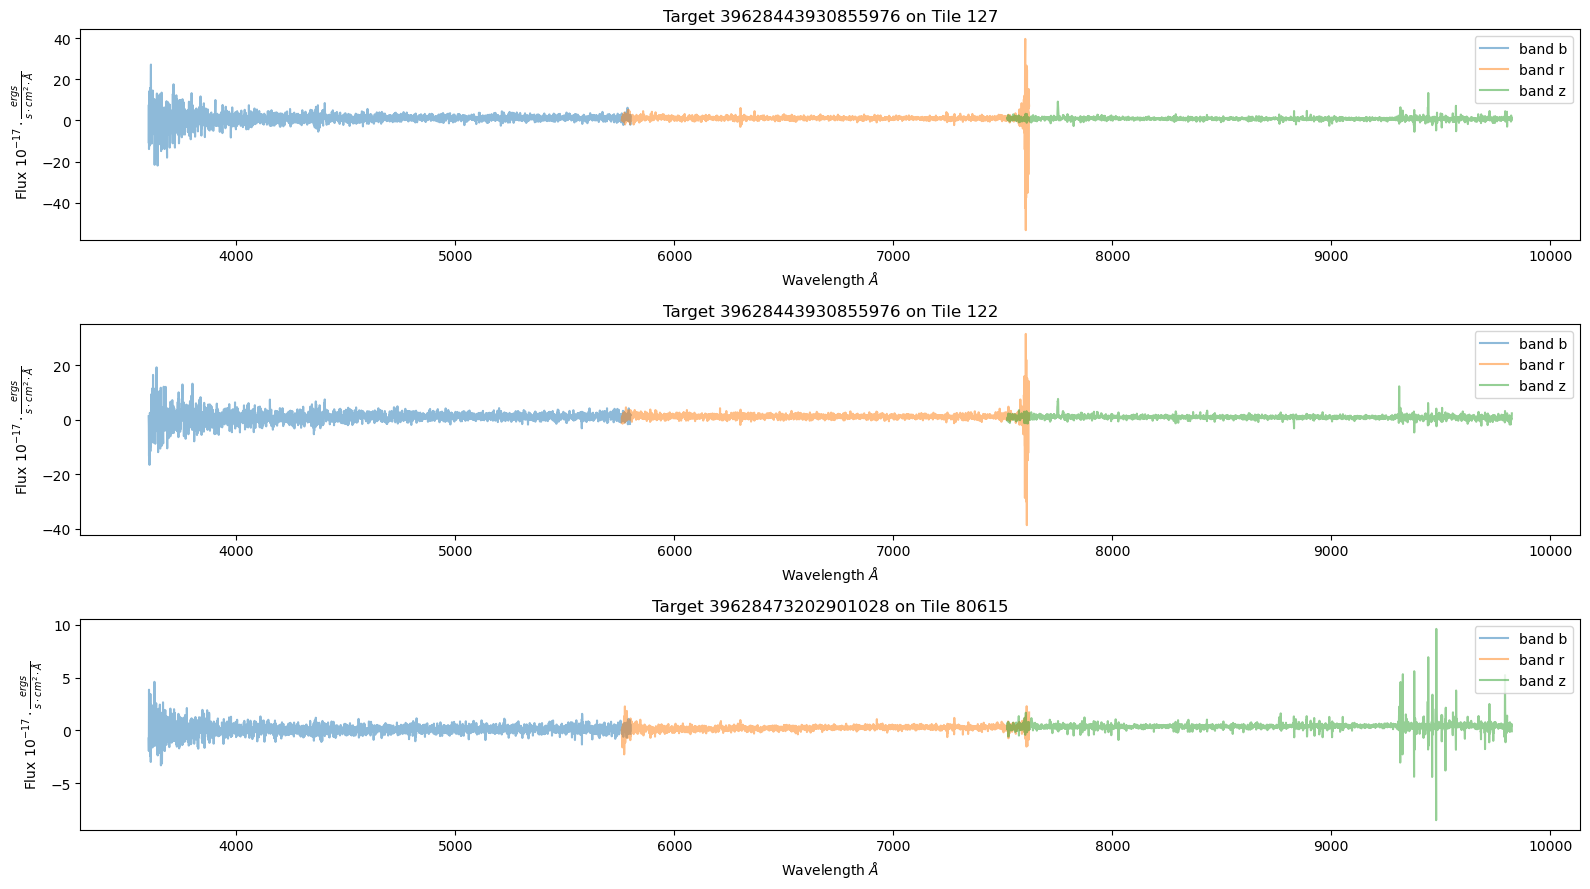

In [18]:
num = len(spectra.fibermap)
fig, axs = plt.subplots(num, 1, figsize=(16,num*3))
if num == 1:
    axs = np.array([axs])
for i in range(num):
    plotSpectra(spectra, axs, i)
fig.tight_layout()

In [142]:
params = {"targetID":39628454567608809}
targetid = int(params.get("targetID"))
q = db.dbSession.query(db.Fiberassign.tileid, db.Tile.lastnight, db.Fiberassign.petal_loc).join(db.Tile)
q = q.filter(db.Fiberassign.targetid == targetid and db.Fiberassign.tileid == db.Tile.tileid)